## Подготовка данных

In [1]:
# импорт бибилотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [2]:
# откроем таблицу с разметкой
df = pd.read_csv('/datasets/faces/labels.csv')
# выведем на экран размер и первые 3 строки
display(df.shape)
display(df.head(3))
display(df.describe())

(7591, 2)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [3]:
# создадим загрузчик данных
datagen = ImageDataGenerator(rescale=1/255.)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    seed=571)

Found 7591 validated image filenames.


### Визуализация данных

(97, 1)

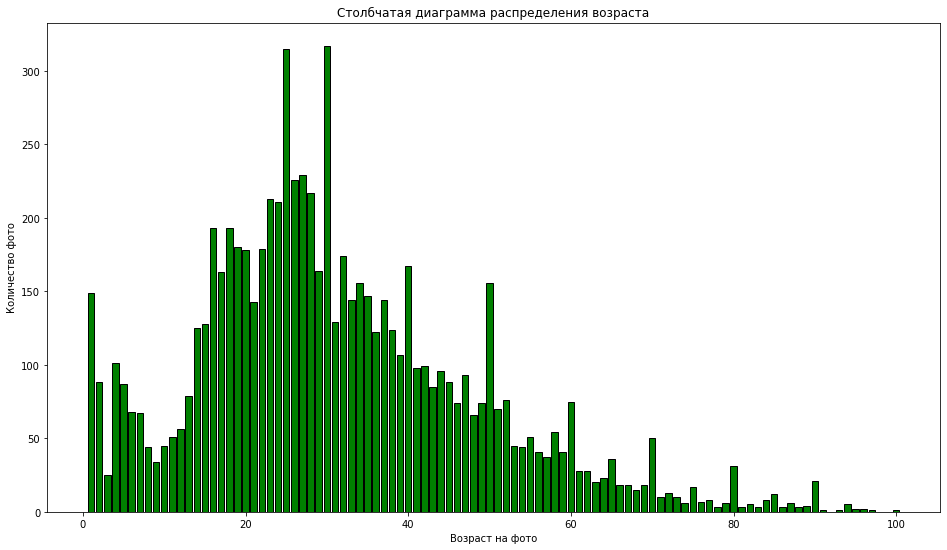

In [4]:
# подготовим сводную таблицу
table = pd.DataFrame(df['real_age'].value_counts())
display(table.shape)
# построение стобчатого графика 
plt.figure(figsize=(16, 9))
plt.bar(x = table.index, height = table.real_age, color = 'green', edgecolor = 'black');
plt.title('Столбчатая диаграмма распределения возраста')
plt.xlabel('Возраст на фото')
plt.ylabel('Количество фото');

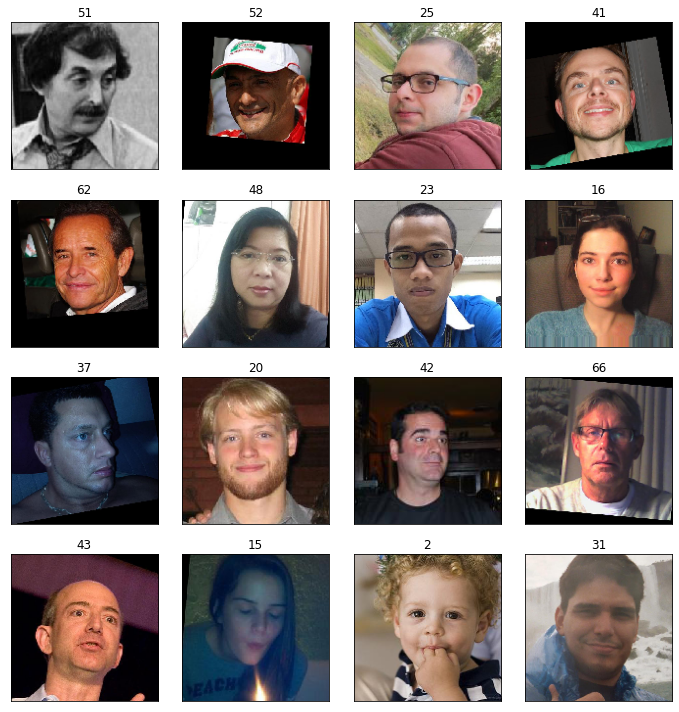

In [5]:
# подготовим признаки и цели
features, target = next(datagen_flow)
# выведем изображения
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- В распоряжении всего 7591 фотография.
- Уникальных значений возраста всего 97 шт (от 1 до 100 лет).
- Больше всего представлено фотографий для людей в возрасте от 16 до 40.
- Меньше всего представлено фотографий для людей в возрасте 75 и более лет.
- В датасете фотографии есть как в чернобелом формате так и цветном, а также имеются черные рамки на фото не параллельные границам фотографий.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np




def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., horizontal_flip=True, 
                                 rotation_range=90, width_shift_range=0.1, height_shift_range=0.1)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)    
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.00009)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Downloading data from https://github.com/keras-team/
keras-applications/releases/download/resnet/
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 78s - loss: 270.1369 - mae: 12.3114 - val_loss: 733.5003 - val_mae: 21.9853

Epoch 2/10
356/356 - 73s - loss: 144.6673 - mae: 9.1671 - val_loss: 145.7874 - val_mae: 9.1840

Epoch 3/10
356/356 - 73s - loss: 128.9584 - mae: 8.7216 - val_loss: 142.3362 - val_mae: 8.8656

Epoch 4/10
356/356 - 71s - loss: 112.4724 - mae: 8.1231 - val_loss: 110.8481 - val_mae: 7.8337

Epoch 5/10
356/356 - 70s - loss: 105.1366 - mae: 7.8815 - val_loss: 105.9485 - val_mae: 7.7364

Epoch 6/10
356/356 - 66s - loss: 95.8949 - mae: 7.5231 - val_loss: 106.0438 - val_mae: 7.8311

Epoch 7/10
356/356 - 72s - loss: 89.9483 - mae: 7.2474 - val_loss: 113.4636 - val_mae: 8.3538

Epoch 8/10
356/356 - 71s - loss: 85.2958 - mae: 7.1261 - val_loss: 121.0784 - val_mae: 8.5469

Epoch 9/10
356/356 - 72s - loss: 79.3118 - mae: 6.8213 - val_loss: 102.7683 - val_mae: 7.5556

Epoch 10/10
356/356 - 72s - loss: 71.6110 - mae: 6.4261 - val_loss: 112.0208 - val_mae: 7.7415

119/119 - 10s - loss: 112.0208 - mae: 7.7415
Test MAE: 7.7415

```

### Вывод

- В основе модели лежит сверточная сеть ResNet50.
- Всего выбрано 10 эпох для обучения.
- На обучающей выборке, лучший результат МАЕ равен 6.4
- На тестовой выборке, лучший результат МАЕ равен 7.7

## Анализ обученной модели

### Итоговый вывод

- Для обучения модели применена аугментация, веса для модели взяты на основе `imagenet`, тестовая выборка взята в размере 25% от всей выборки фотографий.
- Обучение модели нейронной сети на GPU многократно ускоряет работу по сравнению с обучением на CPU.
- Модель сверточной нейронной сети показыввает высокую эффективность в предсказании возраста покупателя.
- Полученное значение МАЕ 7.4 - хороший показатель, так как в общемировой практике покупателей разделяют по возрасту в рамках группы, например 15-24 лет, что показывает разброс порядка 9 лет, а данный показатель близок к полученному значению МАЕ.
- Первую задачу с предложением товаров группе покупателей в зависимости от возраста модель определенно должна решать очень хорошо, так как МАЕ не превышает границ возрастных групп.
- Вторую задачу с контролированием добросовестности кассиров при продаже алкоголя, текущаю модель может решать, но возможно должна быть дообучена, либо должна быть применена дополнительная функция отслеживания предъявления документа на кассе.